In [156]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from ta.volatility import BollingerBands

DATA_DIR = '../databases/'
from utils.core import (
    load_csvs_from_folder
)


import warnings
warnings.filterwarnings('ignore')


In [157]:
data_dict = load_csvs_from_folder(DATA_DIR)
for ticker in data_dict:
    df_temp = data_dict[ticker]
    df_temp['ret'] = df_temp['close'].pct_change()
    data_dict[ticker] = df_temp

tickers = list(data_dict.keys())
print(f"Loaded datasets: {list(data_dict.keys())}")



Loaded datasets: ['BTCUSD', 'DBC', 'SPX', 'XLRE']


In [158]:
def prepare_bb_band_strategy(ohlc_df, window=20, window_dev=2.0):
    """
    Estratégia clássica:
    - Se Close(t-1) fecha abaixo da banda inferior -> entra long em t
    - Se Close(t-1) fecha acima da banda superior -> entra short em t
    - Sai quando o fechamento volta para dentro do canal (reentrada)
    """
    df = ohlc_df.copy()


    # Bollinger Bands
    bb = BollingerBands(close=df["close"], window=window, window_dev=window_dev)
    df["bb_mid"] = bb.bollinger_mavg()
    df["bb_upper"] = bb.bollinger_hband()
    df["bb_lower"]  = bb.bollinger_lband()

    # posição (1=long, -1=short, 0=flat)
    pos = np.zeros(len(df), dtype=int)
    in_pos = 0

    for i in range(1, len(df)):
        c_prev  = df["close"].iloc[i-1]
        hi_prev = df["bb_upper"].iloc[i-1]
        lo_prev = df["bb_lower"].iloc[i-1]

        # saída: reentrada no canal no candle anterior
        if in_pos == 1 and c_prev >= lo_prev:
            in_pos = 0
        elif in_pos == -1 and c_prev <= hi_prev:
            in_pos = 0

        # entrada: apenas se estiver flat
        if in_pos == 0:
            if c_prev < lo_prev:
                in_pos = 1
            elif c_prev > hi_prev:
                in_pos = -1

        pos[i] = in_pos

    df["position"] = pos
    df['buy_signal'] = np.where(df['position']==1, 1, False)
    df['sell_signal'] = np.where(df['position']==-1, -1, False)
    
    df.loc[:,'signal'] = np.where(df.loc[:,'buy_signal'], 1,
                                 np.where(df.loc[:,'sell_signal'], -1 ,0))
    df['signal'] = df['signal'].astype(int)
    
    df["signal_expanded"] = (
         df["signal"]
        .where(df["signal"] != 0)
        .ffill(limit=10) 
        .fillna(0)
        .astype(int)
    )
                                 

    df["strategy_ret"] = df["signal_expanded"].shift(1).fillna(0) * df["ret"]

    df["strategy"] = df["strategy_ret"].add(1).cumprod().sub(1)
    df["buy_hold"] = df["ret"].add(1).cumprod().sub(1)

    return df

for ticker in data_dict:
    data_dict[ticker] = prepare_bb_band_strategy(data_dict[ticker])


In [159]:
data_dict['SPX'].tail()

,close,high,low,open,volume,ret,bb_mid,bb_upper,bb_lower,position,buy_signal,sell_signal,signal,signal_expanded,strategy_ret,strategy,buy_hold
Date,,,,,,,,,,,,,,,,,
2026-01-05,6902.049805,6920.379883,6891.560059,6892.189941,5771930000,0.006354,6858.911987,6963.763610,6754.060364,0,0,0,0,0,0.0,0.547789,3.742960
2026-01-06,6944.819824,6948.689941,6904.020020,6908.029785,5509680000,0.006197,6862.632983,6973.934899,6751.331068,0,0,0,0,0,0.0,0.547789,3.772351
2026-01-07,6920.930176,6965.689941,6919.189941,6945.069824,5214480000,-0.003440,6866.354004,6980.197991,6752.510017,0,0,0,0,0,-0.0,0.547789,3.755934
2026-01-08,6921.459961,6931.279785,6899.330078,6914.109863,5333200000,0.000077,6870.401514,6986.024489,6754.778538,0,0,0,0,0,0.0,0.547789,3.756298
2026-01-09,6966.279785,6978.359863,6917.640137,6927.830078,5163900000,0.006475,6874.381494,6997.226278,6751.536710,0,0,0,0,0,0.0,0.547789,3.787097


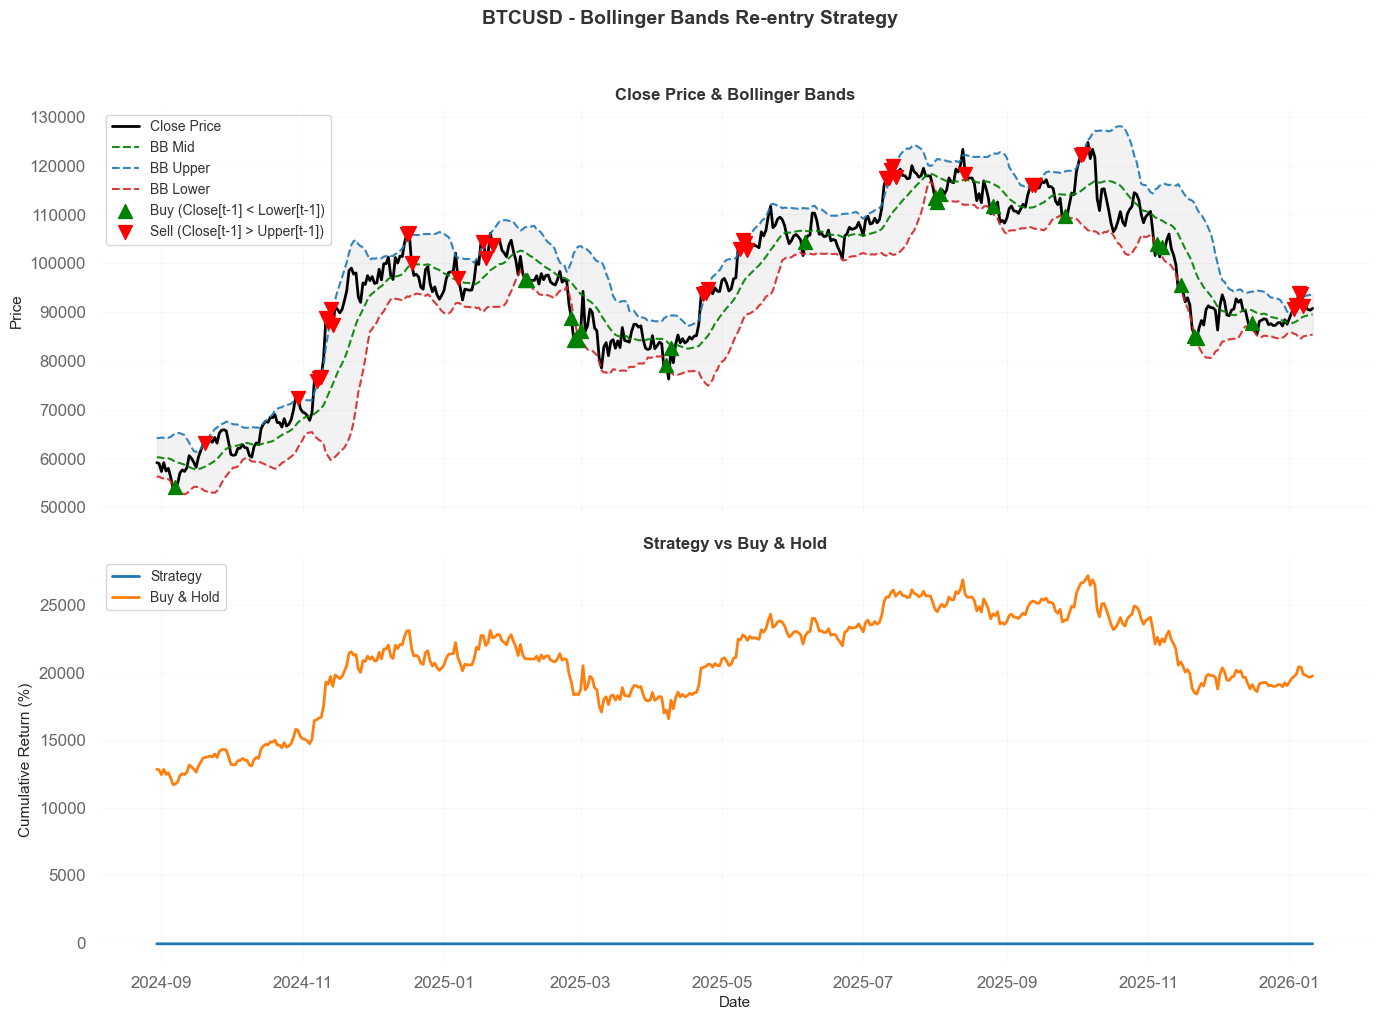

In [160]:
tk_plot = tickers[0]
df_plot = data_dict[tk_plot].tail(500)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# =========================
# ROW 1: CLOSE PRICE + BOLLINGER BANDS
# =========================
ax1.plot(df_plot.index, df_plot["close"], color="black", linewidth=2, label="Close Price")
ax1.plot(df_plot.index, df_plot["bb_mid"],   linestyle="--", linewidth=1.5, alpha=0.9, label="BB Mid", color='green')
ax1.plot(df_plot.index, df_plot["bb_upper"], linestyle="--", linewidth=1.5, alpha=0.9, label="BB Upper", color='tab:blue')
ax1.plot(df_plot.index, df_plot["bb_lower"], linestyle="--", linewidth=1.5, alpha=0.9, label="BB Lower", color='tab:red')
ax1.fill_between(df_plot.index, df_plot["bb_lower"], df_plot['bb_upper'], alpha=0.1, color="gray")

buy_signals = df_plot[df_plot["buy_signal"] == 1]
ax1.scatter(buy_signals.index, buy_signals["close"], color="green", marker="^", s=100,
            label="Buy (Close[t-1] < Lower[t-1])", zorder=5)
sell_signals = df_plot[df_plot["sell_signal"] == -1]
ax1.scatter(sell_signals.index, sell_signals["close"], color="red", marker="v", s=100,
            label="Sell (Close[t-1] > Upper[t-1])", zorder=5)

ax1.set_ylabel("Price", fontsize=11)
ax1.set_title("Close Price & Bollinger Bands", fontsize=12, fontweight="bold")
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(True, alpha=0.3)

# =========================
# ROW 2: STRATEGY vs BUY & HOLD
# =========================
ax2.plot(df_plot.index, df_plot["strategy"] * 100, linewidth=2, label="Strategy", color='tab:blue')
ax2.plot(df_plot.index, df_plot["buy_hold"] * 100, linewidth=2, label="Buy & Hold", color='tab:orange')
ax2.set_ylabel("Cumulative Return (%)", fontsize=11)
ax2.set_xlabel("Date", fontsize=11)
ax2.set_title("Strategy vs Buy & Hold", fontsize=12, fontweight="bold")
ax2.legend(loc="upper left", fontsize=10)
ax2.grid(True, alpha=0.3)

fig.suptitle(f"{tk_plot} - Bollinger Bands Re-entry Strategy", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(f"../images/BB_Bands_sample.png", dpi=200)
plt.show()


In [161]:
def summarize(df_in):
       if df_in.empty:
           return df_in
       stats_mean = df_in.mean().tolist()
       stats_median = df_in.median().tolist()
       average_negative = df_in[df_in < 0].mean().tolist()
       average_positive = df_in[df_in > 0].mean().tolist()
       pct_positive = (df_in > 0).sum() / len(df_in)
       pct_positive = pct_positive.tolist()
       df_stats = pd.DataFrame(columns=df_in.columns)
       df_stats.loc['Média'] = stats_mean
       df_stats.loc['Mediana'] = stats_median
       df_stats.loc['Média dos Negativos'] = average_negative
       df_stats.loc['Média dos positivos'] = average_positive
       df_stats.loc['Porcentagem de Qtde. Positivos'] = pct_positive
       return df_stats

def fn_analyze_signals(df, price_col = 'close'):
    '''
    Compute returns following buy (signal==1) and sell (signal==-1) signals and
    return two DataFrames with statistics for multiple horizons.
    '''
    signals_long = 0
    signals_short = 0
    returns_long = {}
    returns_short = {}
    dates_loc = []
    max_horizon = 22
    horizons = [5, 10, 22]

    for i in range(0, (len(df) - max_horizon)):
        sig = df.get('signal').iloc[i] if 'signal' in df.columns else 0
        if sig == 1:
            signals_long += 1
            date = df.index[i].strftime('%Y-%m-%d')
            dates_loc.append(i)
            return_signal = []
            for h in horizons:
                return_signal.append((np.log(df[price_col].iloc[i + h]) - np.log(df[price_col].iloc[i])))
            returns_long[date] = return_signal
        elif sig == -1:
            signals_short += 1
            date = df.index[i].strftime('%Y-%m-%d')
            dates_loc.append(i)
            return_signal = []
            for h in horizons:
                return_signal.append((np.log(df[price_col].iloc[i + h]) - np.log(df[price_col].iloc[i])))
            returns_short[date] = return_signal

    # Build DataFrames where rows are signal dates and columns are horizons
    df_long = pd.DataFrame(returns_long).T if returns_long else pd.DataFrame()
    df_short = pd.DataFrame(returns_short).T if returns_short else pd.DataFrame()

    # Name columns by horizon for clarity
    col_names = [f'h_{h}' for h in horizons]
    if not df_long.empty:
        df_long.columns = col_names
    if not df_short.empty:
        df_short.columns = col_names


    df_stats_long = summarize(df_long)
    df_stats_short = summarize(df_short)

    return df_stats_long, df_stats_short,signals_long, signals_short

In [162]:
# Analyze all tickers in data_dict and store results keyed by ticker
stats_dict = {}
signals_counts = {}
dates_dict = {}
for tk, df_t in data_dict.items():
    try:
        df_long, df_short, signals_long, signals_short = fn_analyze_signals(df_t)
    except Exception as e:
        print(f'Error analyzing {tk}: {e}')
        stats_dict[tk] = {'long': pd.DataFrame(), 'short': pd.DataFrame()}
        dates_dict[tk] = []
        continue
    stats_dict[tk] = {'long': df_long, 'short': df_short}
    signals_counts[tk] = {'long': signals_long, 'short': signals_short}

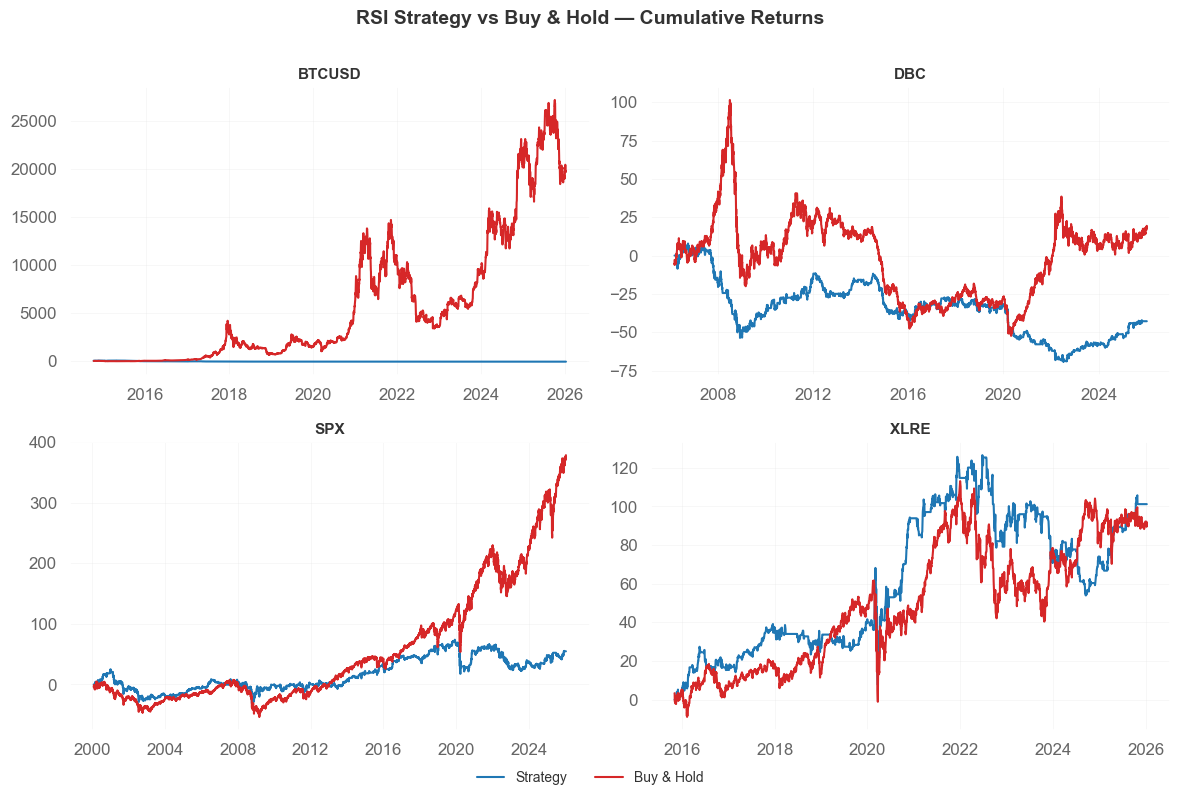

In [163]:
# ======================================
# CONFIG
# ======================================
tickers_to_plot = tickers[:4]  # garante 4 ativos
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
axes = axes.flatten()

# ======================================
# LOOP DE PLOT
# ======================================
for ax, ticker in zip(axes, tickers_to_plot):
    df = data_dict[ticker].copy().dropna()

    # Retornos acumulados (%)
    strat_cum = df["strategy"]* 100
    bh_cum    = df['buy_hold'] * 100

    ax.plot(df.index, strat_cum, label="Strategy",color='tab:blue')
    ax.plot(df.index, bh_cum, label="Buy & Hold",color='tab:red')

    ax.set_title(ticker, fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)


# ======================================
# AJUSTES GERAIS
# ======================================
fig.suptitle(
    "RSI Strategy vs Buy & Hold — Cumulative Returns",
    fontsize=14,
    fontweight="bold"
)

# Legenda única
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=10
)

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()


In [164]:
from IPython.display import display, HTML
reports_html = []

for report_ticker in tickers:
    # Dados (multiplica por 100 para converter em %)
    long_df = stats_dict.get(report_ticker, {}).get("long", pd.DataFrame()) * 100
    short_df = stats_dict.get(report_ticker, {}).get("short", pd.DataFrame()) * 100

    n_long = signals_counts.get(report_ticker, {}).get("long", 0)
    n_short = signals_counts.get(report_ticker, {}).get("short", 0)

    # Formatador para exibir valores com símbolo %
    fmt = lambda x: f"{x:.2f}%"

    # Tabelas em HTML (estilo inline para melhor compatibilidade)
    if not long_df.empty:
        long_html = long_df.applymap(fmt).to_html(
            index=True,
            border=0,
            justify="center",
            escape=False
        )
    else:
        long_html = "<p><em>Nenhum sinal long identificado.</em></p>"

    if not short_df.empty:
        short_html = short_df.applymap(fmt).to_html(
            index=True,
            border=0,
            justify="center",
            escape=False
        )
    else:
        short_html = "<p><em>Nenhum sinal short identificado.</em></p>"

    # Bloco HTML final (2 colunas: Long | Short lado a lado)
    html_block = f"""
<h2 style="text-align:center;">{report_ticker} — Análise da Estratégia BB Bands</h2>

<p style="text-align:center;"><strong>Resumo dos sinais</strong><br>
<strong>Sinais Long (sobrevenda):</strong> {n_long} &nbsp;|&nbsp;
<strong>Sinais Short (sobrecompra):</strong> {n_short}
</p>

<hr>

<div style="display:flex; gap:12px; flex-wrap:wrap; justify-content:center;">
  <div style="flex:1; min-width:300px;">
    <h3>📈 Sinais Long — Retornos condicionais</h3>
    {long_html}
  </div>
  <div style="flex:1; min-width:300px;">
    <h3>📉 Sinais Short — Retornos condicionais</h3>
    {short_html}
  </div>
</div>
"""

    reports_html.append(html_block.strip())


final_html_report = "\n\n<hr style='margin:32px 0;'>\n\n".join(reports_html)

display(HTML(final_html_report))

,h_5,h_10,h_22
Média,0.45%,0.66%,0.40%
Mediana,1.16%,0.46%,0.23%
Média dos Negativos,-8.01%,-8.63%,-13.15%
Média dos positivos,5.91%,9.01%,13.37%
Porcentagem de Qtde. Positivos,60.75%,52.69%,51.08%
,h_5,h_10,h_22
Média,2.70%,4.42%,7.00%
Mediana,1.33%,2.78%,4.30%
Média dos Negativos,-4.01%,-6.93%,-8.66%
Média dos positivos,6.99%,10.07%,16.43%


In [165]:
import pandas as pd
import numpy as np
import quantstats as qs

def calculate_stats(returns, periods_per_year=252):
    """Calcula estatísticas focadas para investidores intermediários usando QuantStats."""
    returns = returns.dropna()
    if len(returns) == 0:
        return {}
    
    # Usando QuantStats para calcular as métricas
    total_return = qs.stats.comp(returns) * 100  # Retorno total composto
    cagr = qs.stats.cagr(returns,) * 100  # CAGR
    volatility = qs.stats.volatility(returns, periods=periods_per_year) * 100  # Volatilidade anualizada
    sharpe = qs.stats.sharpe(returns, periods=periods_per_year)  # Sharpe Ratio
    max_dd = qs.stats.max_drawdown(returns) * 100  # Max Drawdown
    win_rate = qs.stats.win_rate(returns) * 100  # Win Rate
    profit_factor = qs.stats.profit_factor(returns)  # Profit Factor
    
    return {
        'Retorno Total': total_return,
        'CAGR': cagr,
        'Volatilidade': volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor
    }

# Cria df_metrics com dados para cada ticker
rows = []
for ticker, df in data_dict.items():
    strat_stats = calculate_stats(df['strategy_ret'])
    bh_stats = calculate_stats(df['ret'])
    
    for metric in strat_stats.keys():
        rows.append({
            'Ticker': ticker,
            'Métrica': metric,
            'Estratégia': strat_stats[metric],
            'Buy & Hold': bh_stats[metric],
            'Diferença': strat_stats[metric] - bh_stats[metric]
        })

df_metrics = pd.DataFrame(rows)

In [166]:
from IPython.display import display, HTML
import html as _html

def generate_dark_report(df_metrics):
    """Gera relatório HTML em dark mode sem injetar <style> global."""

    container_style = (
        "display:flex; flex-wrap:wrap; "
        "column-gap:28px; row-gap:28px; "   # <-- espaço entre os cards (ajuste aqui)
        "background:#1a1a1a; padding:15px;"
    )
    card_style = (
        "border:1px solid #333; padding:12px; "
        "min-width:380px; background:#252525;"
    )
    title_style = (
        "font-size:1.1em; font-weight:bold; text-align:center; "
        "color:#fff; border-bottom:1px solid #444; "
        "padding-bottom:8px; margin-bottom:10px;"
    )
    table_style = "width:100%; border-collapse:collapse;"
    th_style = (
        "background:#333; color:#ccc; padding:8px; "
        "text-align:right; border:1px solid #444;"
    )
    th_first_style = th_style + " text-align:left;"
    td_style = (
        "padding:8px; color:#ddd; text-align:right; "
        "border:1px solid #444; background:#2a2a2a;"
    )
    td_first_style = td_style + " text-align:left;"

    html = f"<div style='{container_style}'>"

    tickers = df_metrics["Ticker"].unique()

    for ticker in tickers:
        ticker_data = df_metrics[df_metrics["Ticker"] == ticker]

        html += (
            f"<div style='{card_style}'>"
            f"<div style='{title_style}'>{_html.escape(str(ticker))}</div>"
            f"<table style='{table_style}'>"
            f"<tr>"
            f"<th style='{th_first_style}'>Métrica</th>"
            f"<th style='{th_style}'>Estratégia</th>"
            f"<th style='{th_style}'>Buy &amp; Hold</th>"
            f"<th style='{th_style}'>Diferença</th>"
            f"</tr>"
        )

        for _, row in ticker_data.iterrows():
            metric = row["Métrica"]
            strat = row["Estratégia"]
            bh = row["Buy & Hold"]
            diff = row["Diferença"]

            if ("Ratio" in metric) or ("Factor" in metric):
                s_fmt = f"{strat:.2f}"
                b_fmt = f"{bh:.2f}"
                d_fmt = f"{diff:+.2f}"
            else:
                s_fmt = f"{strat:.2f}%"
                b_fmt = f"{bh:.2f}%"
                d_fmt = f"{diff:+.2f} p.p."

            html += (
                f"<tr>"
                f"<td style='{td_first_style}'>{_html.escape(str(metric))}</td>"
                f"<td style='{td_style}'>{_html.escape(s_fmt)}</td>"
                f"<td style='{td_style}'>{_html.escape(b_fmt)}</td>"
                f"<td style='{td_style}'>{_html.escape(d_fmt)}</td>"
                f"</tr>"
            )

        html += "</table></div>"

    html += "</div>"
    return HTML(html)

# Exibe o relatório
display(generate_dark_report(df_metrics))


Métrica,Estratégia,Buy & Hold,Diferença
Retorno Total,-99.62%,19744.40%,-19844.02 p.p.
CAGR,-28.84%,38.06%,-66.89 p.p.
Volatilidade,44.40%,55.78%,-11.38 p.p.
Sharpe Ratio,-0.54,0.86,-1.40
Max Drawdown,-99.85%,-83.40%,-16.45 p.p.
Win Rate,47.65%,52.63%,-4.98 p.p.
Profit Factor,0.87,1.18,-0.31
Métrica,Estratégia,Buy & Hold,Diferença
Retorno Total,-42.84%,19.36%,-62.20 p.p.
CAGR,-2.77%,0.89%,-3.67 p.p.


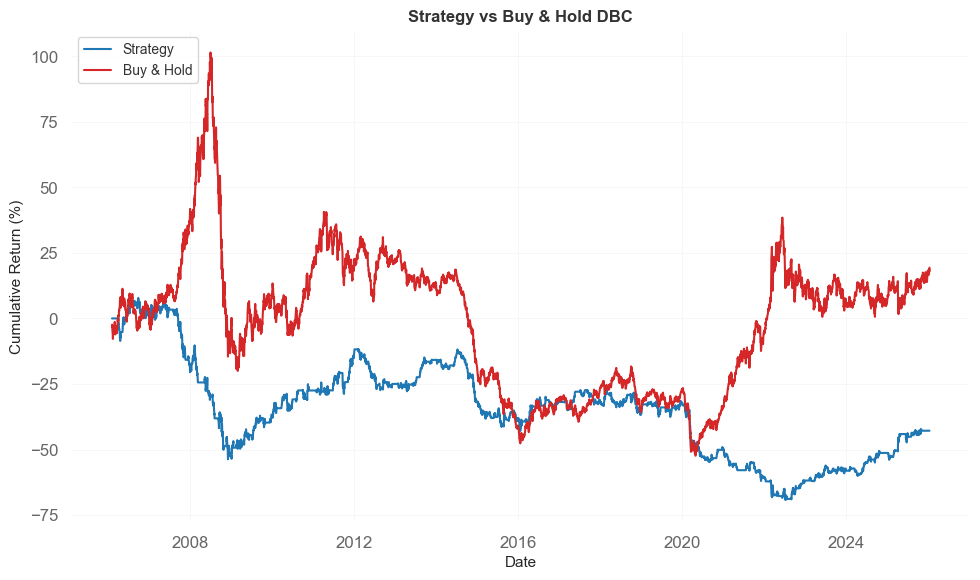

In [167]:
tk_plot = 'DBC'
df_plot = data_dict[tk_plot]

plt.figure(figsize=(10, 6))


plt.plot(df_plot.index, df_plot["strategy"] * 100, label="Strategy", color='tab:blue')
plt.plot(df_plot.index, df_plot["buy_hold"] * 100, label="Buy & Hold", color='tab:red')
plt.ylabel("Cumulative Return (%)", fontsize=11)
plt.xlabel("Date", fontsize=11)
plt.title("Strategy vs Buy & Hold DBC", fontsize=12, fontweight="bold")
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()